# Interactive effects model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [17]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [18]:
# Import dummy variable model
interactive_effects_model = pystan.StanModel(file = '../models/saturated_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f99889c2715e14b840c8576081c80d95 NOW.


In [19]:
iem_data_check = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = 0.01, 
           beta_sd = 0.1, 
           run_estimation = 0)

fit_iem_check = interactive_effects_model.sampling(data=iem_data_check)
fit_iem_df_check = fit_iem_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predictive checks

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12ee4d748>],
      dtype=object)

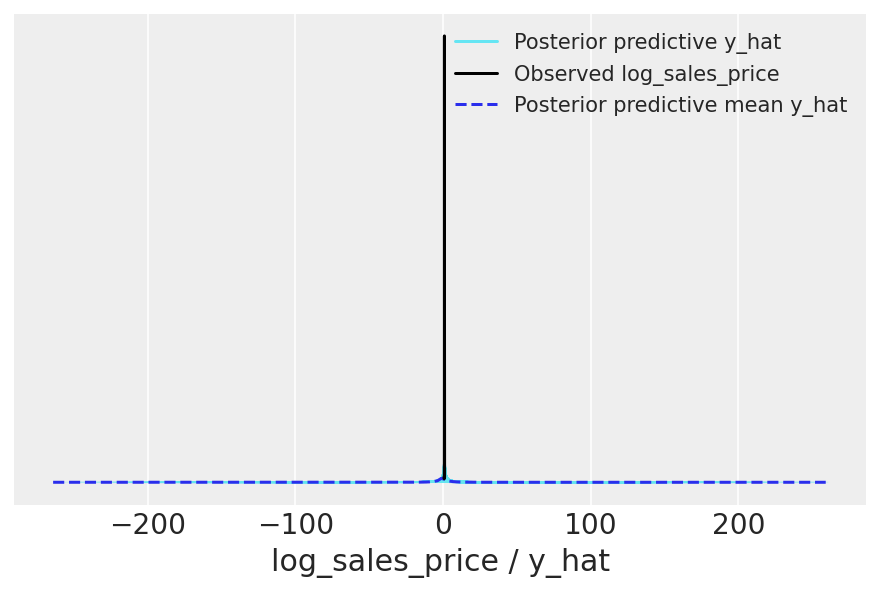

In [7]:
iem_check_az = az.from_pystan(
    posterior=fit_iem_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = iem_check_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

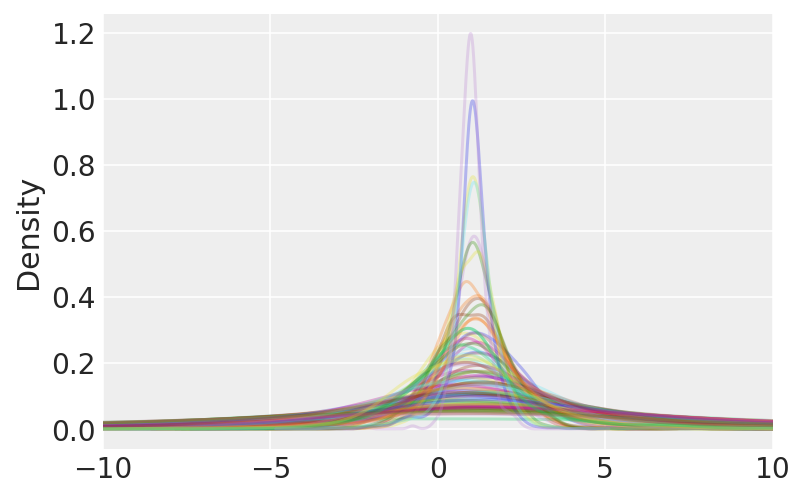

In [8]:
fit_iem_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

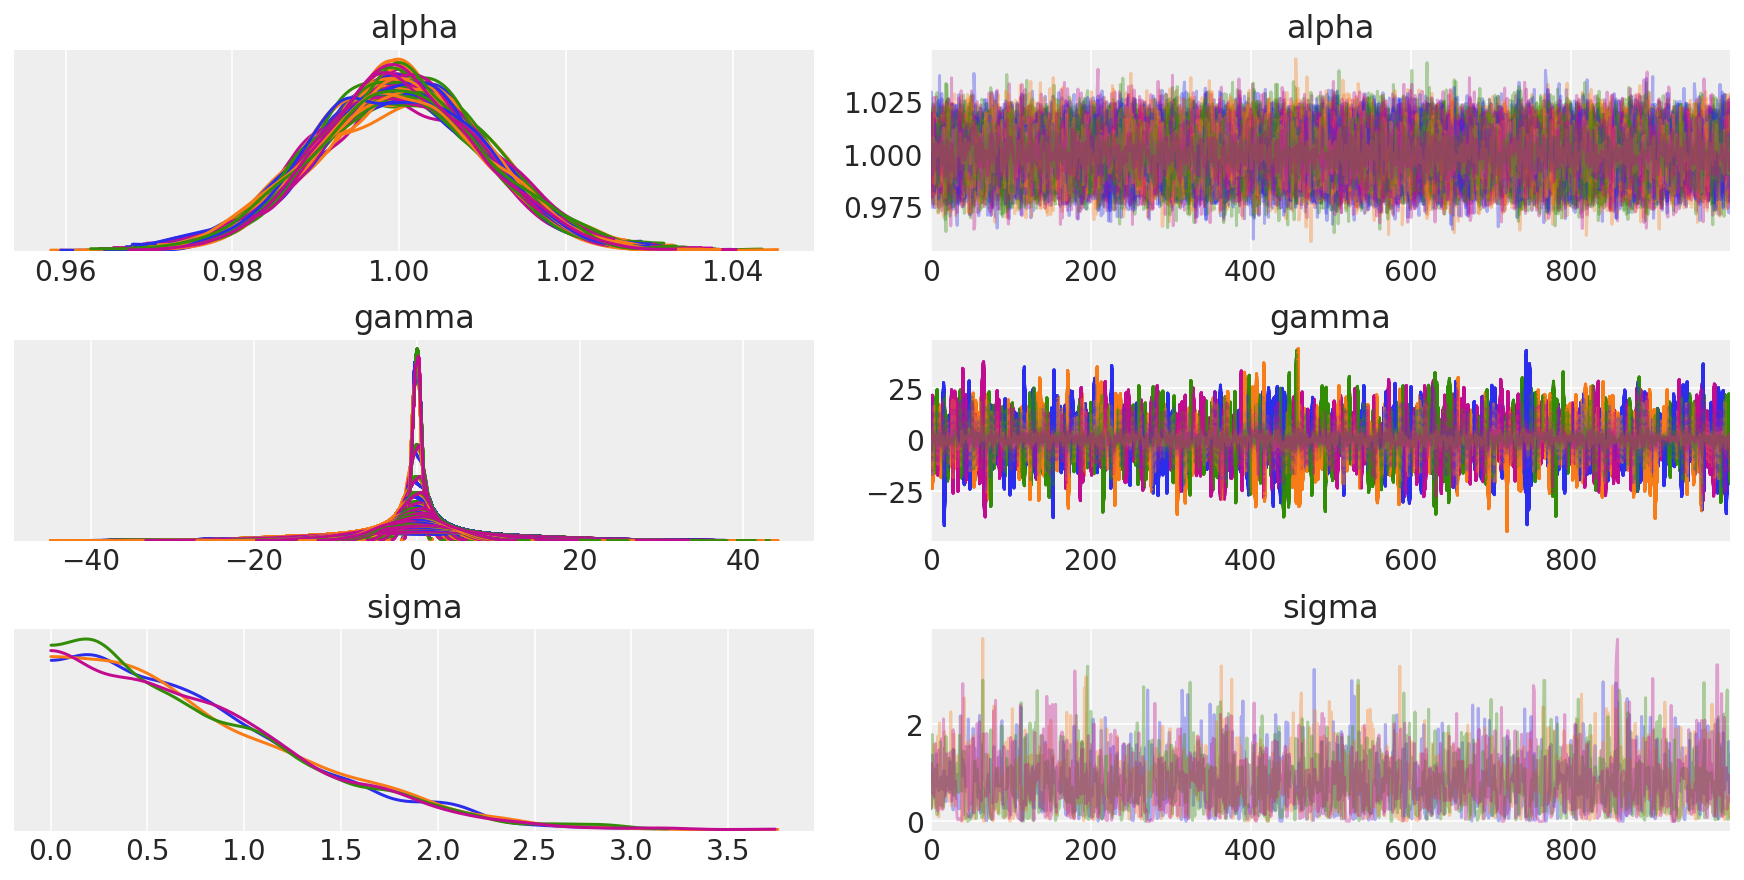

In [9]:
az.plot_trace(fit_iem_check, var_names=["alpha", "gamma", "sigma"], compact = True);

## Fit model on fake data and recapture known parameters

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


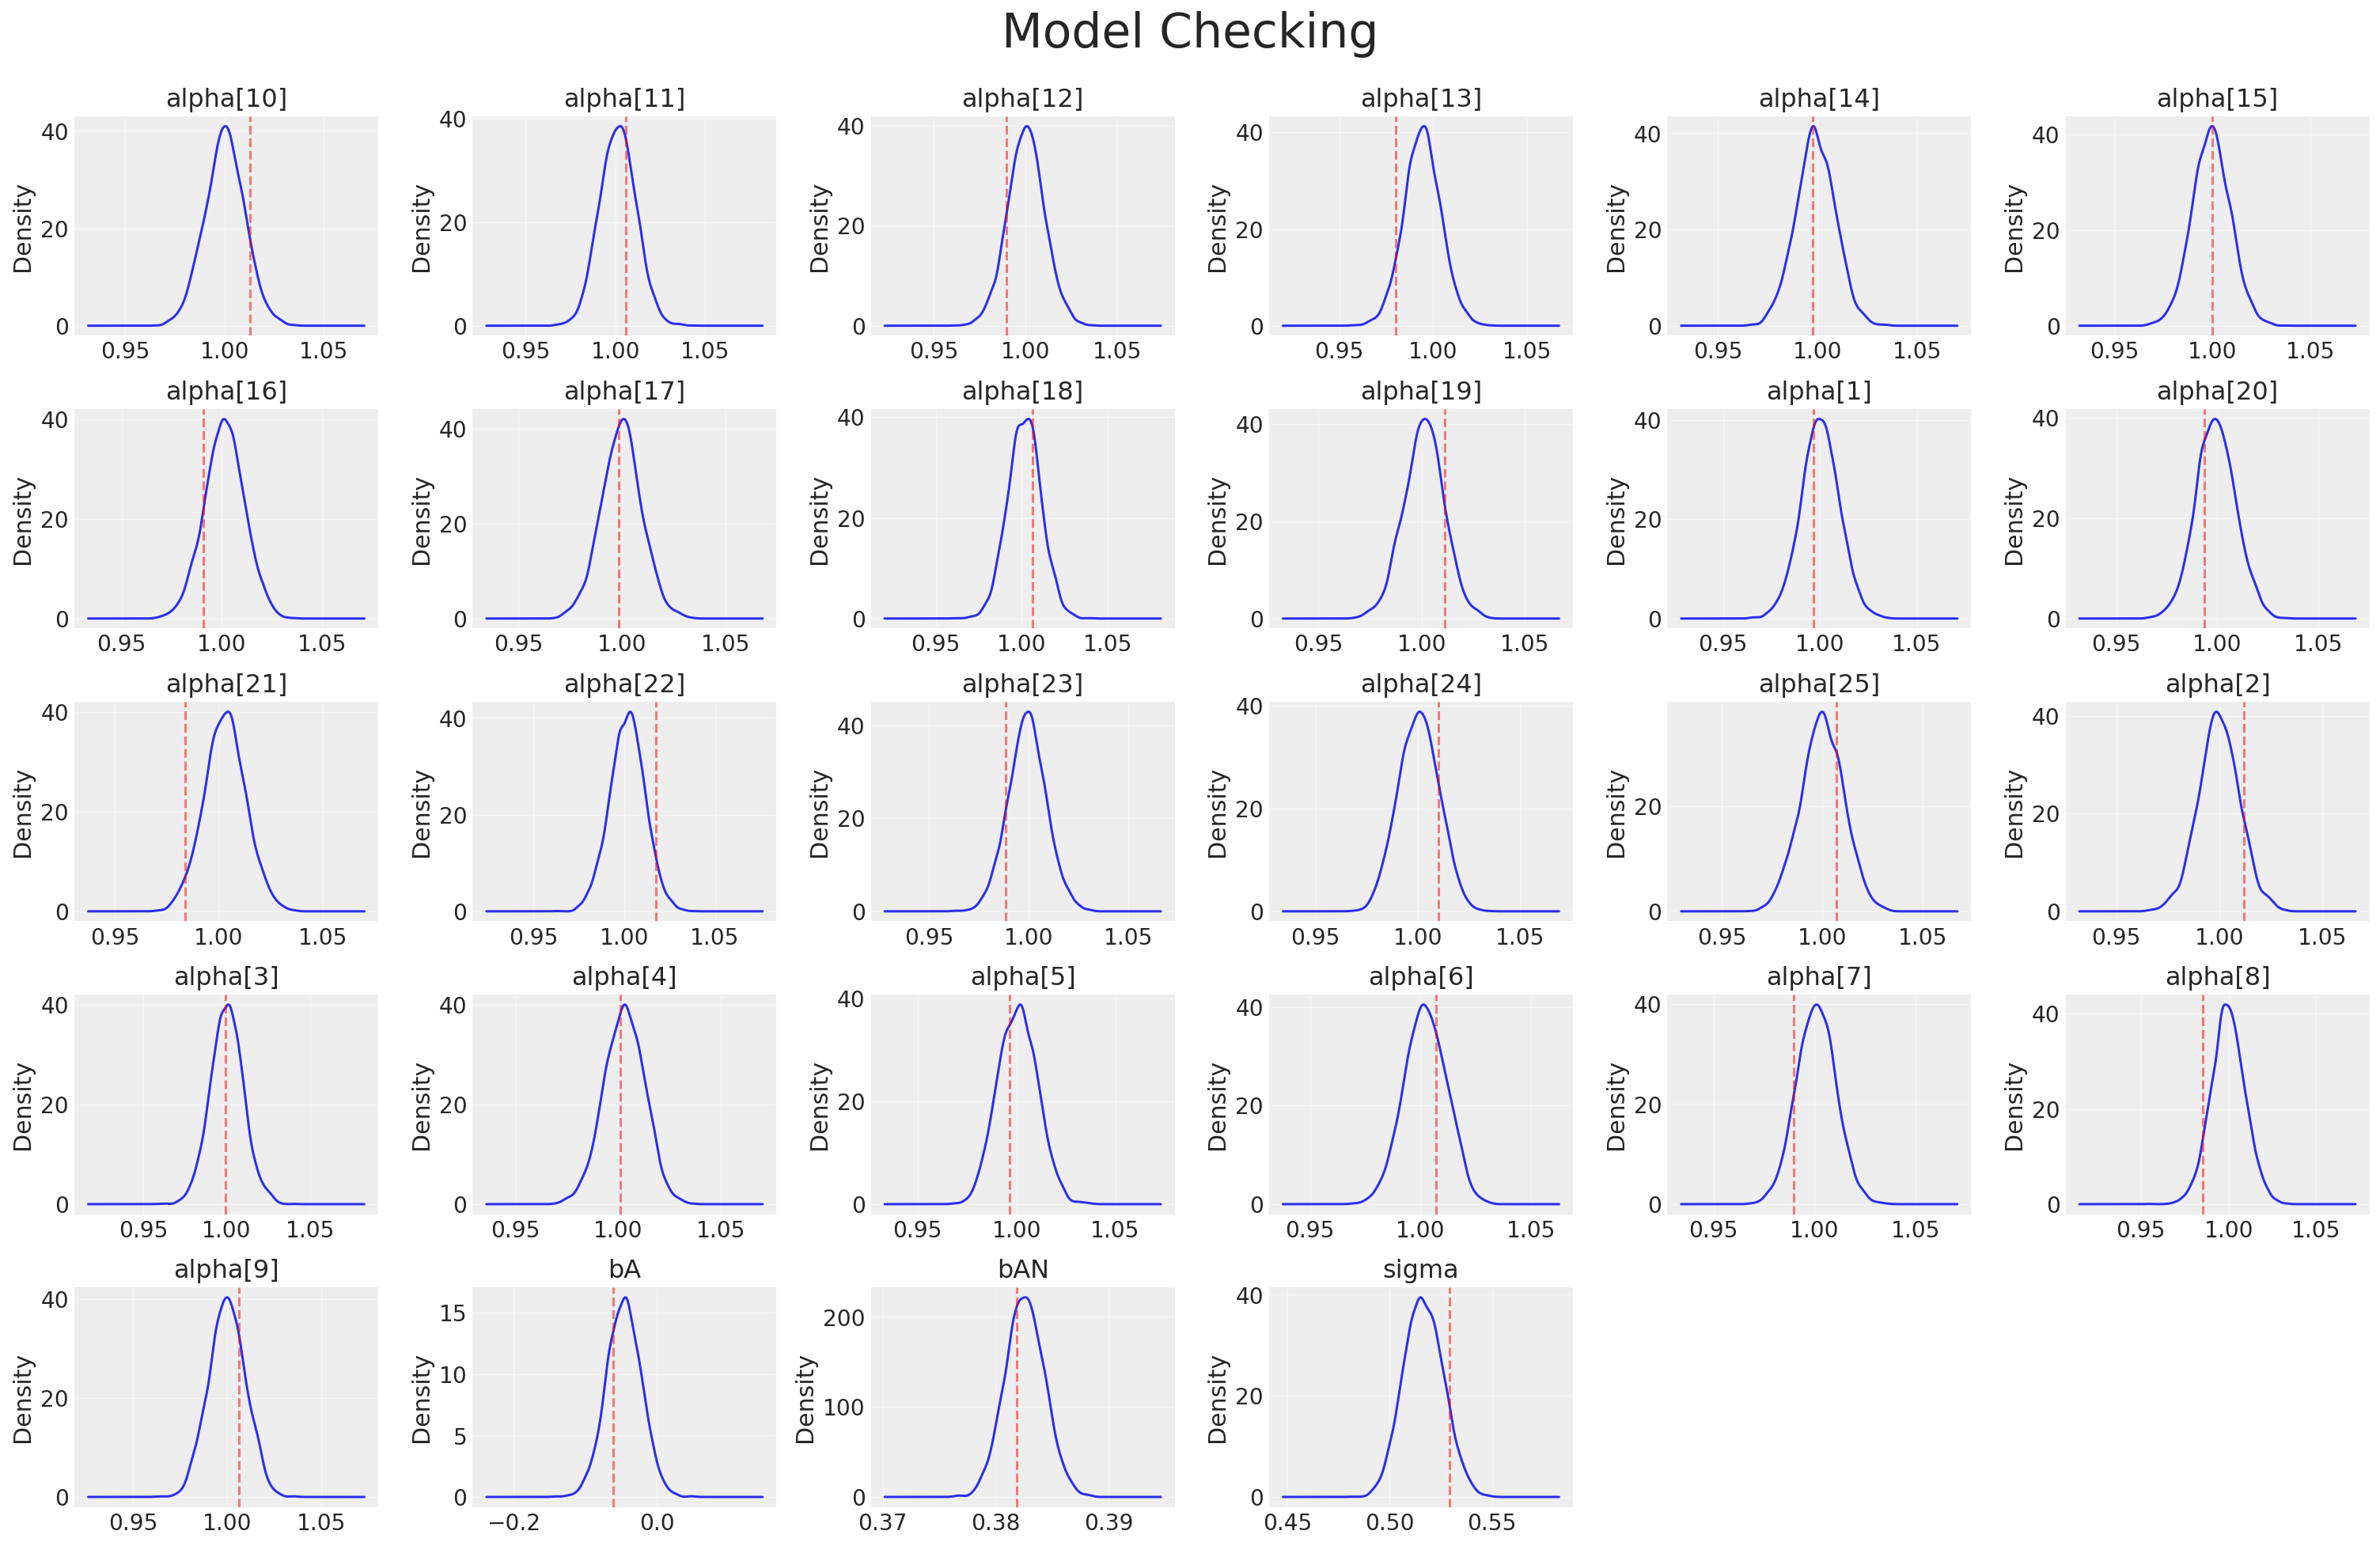

In [30]:
random_draw = 10
y_sim = fit_iem_df_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = fit_iem_df_check.filter(regex = 'alpha|bA|bAN|sigma').iloc[random_draw, :]

_iem_data_check = dict(N = len(train),
              log_sales_price = y_sim,
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

_fit_iem_check = interactive_effects_model.sampling(data=_iem_data_check)
_iem_df_check = _fit_iem_check.to_dataframe()
fake_fit = _iem_df_check.filter(regex = 'alpha|bA|bAN|sigma')
parameter_df = pd.melt(fake_fit)

# Plot
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

## Fit model on real data

In [11]:
iem_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = 0.01, 
           beta_sd = 0.1, 
           run_estimation = 1)

fit_iem = interactive_effects_model.sampling(data=iem_data)
fit_iem_df = fit_iem.to_dataframe()

iem_az = az.from_pystan(
    posterior=fit_iem,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Posterior predictive checks

array([<matplotlib.axes._subplots.AxesSubplot object at 0x144ff2400>],
      dtype=object)

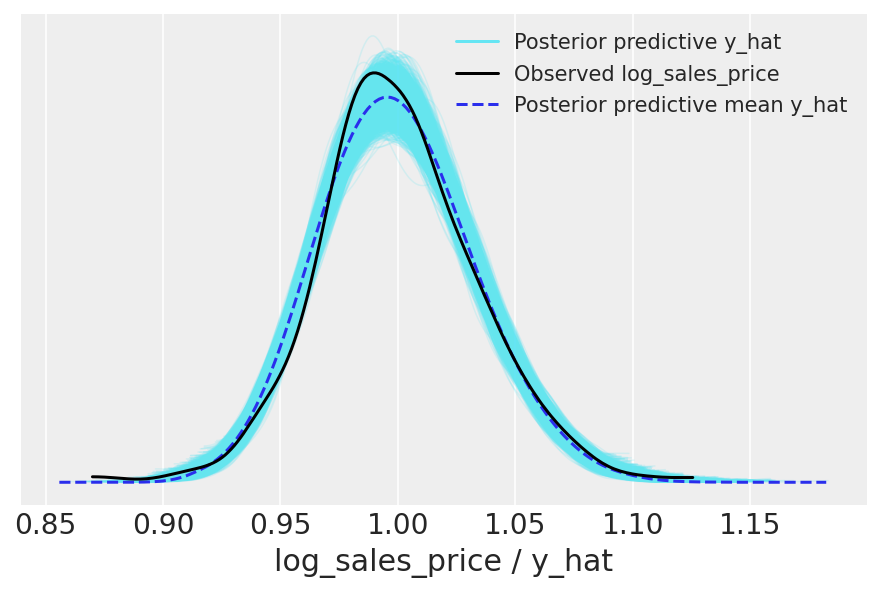

In [12]:
az.plot_ppc(data = iem_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

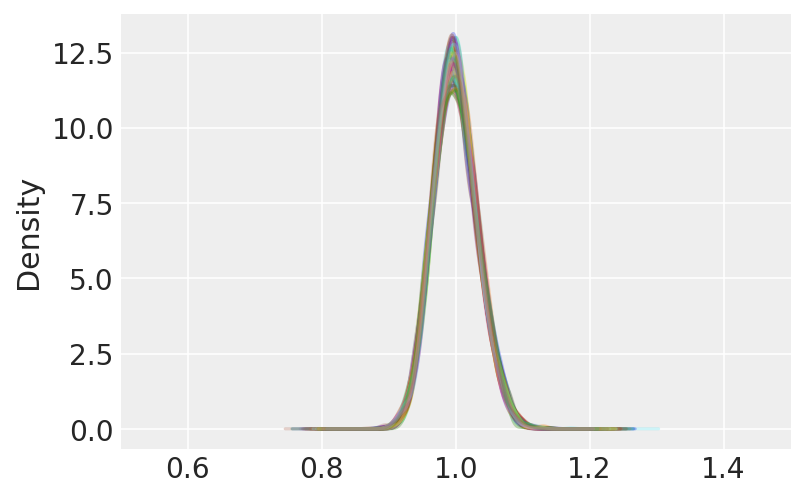

In [14]:
## Posterior predictive checks
fit_iem_df.filter(regex = 'y_test').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (0.5, 1.5));

In [15]:
predictions = pd.DataFrame(np.exp(fit_iem_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

saturated_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

saturated_csv.to_csv('../data/submissions/saturated.csv', index = False)

In [16]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f saturated.csv -m "saturated model (interactive effects)"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:06<00:00, 5.12kB/s]
